# Merging Climate Datasets Exercise

Work through this notebook to practice harmonizing and merging two climate datasets that differ in temporal cadence and spatial resolution.

You will: 
- Load two public NOAA datasets directly from the cloud
- Subset to the continental US (use 230°E–300°E in longitude since the data span 0–360°)
- Use `xr.resample` to aggregate time and `xr.interp` to match grids
- Combine the variables with `xr.merge` for joint analysis

Refer back to the answer key after attempting each step.


## 1. Setup


In [1]:
import matplotlib.pyplot as plt
import xarray as xr

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except ImportError:
    ccrs = None
    cfeature = None

TEMP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.2020.nc"
PRECIP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/cpc_global_precip/precip.2020.nc"

LAT_RANGE = (20, 50)  # degrees North
LON_RANGE_360 = (230, 300)  # degrees East (equivalent to -130° to -60°)
LON_RANGE_180 = (-130, -60)  # convenience if a dataset uses -180° to 180°

TIME_RANGE = slice("2020-06-01", "2020-06-30")


## 2. Load the datasets

Open both remote datasets with `xr.open_dataset`, passing a reasonable chunk size for the time dimension. Assign the resulting objects to `air` and `precip`.


In [2]:
# TODO: load the air temperature and precipitation datasets.
air = xr.open_dataset(TEMP_URL, chunks={"time": 8})
precip = xr.open_dataset(PRECIP_URL, chunks={"time": 8})

## 3. Subset to the continental United States and June 2020

Select the bounding box provided above and limit the time range to June 2020 for both datasets. Store the results in `air_us` and `precip_us`.
Remember that longitude runs from 0° to 360°, so select 230°E–300°E. Check whether each coordinate is ascending or descending before building the slice.


In [3]:
# TODO: subset both datasets using `sel`, handling coordinate ordering as needed.
def subset_us(ds, lon_name="lon", lat_name="lat"):
    lon = ds[lon_name]
    lat = ds[lat_name]
    lon_slice = slice(230, 300) if lon[0] < lon[-1] else slice(300, 230)
    lat_slice = slice(20, 50) if lat[0] < lat[-1] else slice(50, 20)
    return ds.sel({lon_name: lon_slice, lat_name: lat_slice, "time": TIME_RANGE})

air_us = subset_us(air)
precip_us = subset_us(precip)


## 4. Align temporal cadence

Aggregate the six-hourly air temperatures to daily means with `xr.resample`. Name the resulting DataArray `air_daily`.


In [4]:
# TODO: use xr.resample to create daily means.
air_daily = air_us.resample(time="1D").mean()

## 5. Interpolate to the precipitation grid

Use `xr.interp` to interpolate the daily air temperatures onto the precipitation grid (`precip_us.lat` and `precip_us.lon`). Store the interpolated result in `air_interp`.


In [5]:
# TODO: interpolate the resampled temperature field onto the precipitation grid.
air_interp = air_daily.interp(lat=precip_us.lat, lon=precip_us.lon)

## 6. Merge the datasets

Convert the aligned arrays into datasets with clear variable names and merge them with `xr.merge`. Save the output as `merged`.


In [8]:
# TODO: build datasets and merge them into one object named `merged`.
air_ds = air_interp.rename({"air": "air_temperature"})
precip_ds = precip_us.rename({"precip": "daily_precip"})

merged = xr.merge([air_ds, precip_ds])

## 7. Inspect your result

Once your pipeline runs without `NotImplementedError`, evaluate the following cell to sanity-check the merged dataset.


In [9]:
# The assertions below should pass once you have completed the exercise.
assert set(merged.data_vars) == {"air_temperature", "daily_precip"}
assert merged.air_temperature.dims == merged.daily_precip.dims
print(merged)


<xarray.Dataset> Size: 2MB
Dimensions:          (time: 30, lat: 60, lon: 140)
Coordinates:
  * time             (time) datetime64[ns] 240B 2020-06-01 ... 2020-06-30
  * lat              (lat) float32 240B 49.75 49.25 48.75 ... 21.25 20.75 20.25
  * lon              (lon) float32 560B 230.2 230.8 231.2 ... 298.8 299.2 299.8
Data variables:
    air_temperature  (time, lat, lon) float32 1MB dask.array<chunksize=(1, 60, 140), meta=np.ndarray>
    daily_precip     (time, lat, lon) float32 1MB dask.array<chunksize=(8, 60, 140), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
  

## 8. Check In

- Render both variables at the first timestep on a `cartopy` map to verify alignment visually (PlateCarree works well).
- Build a scatter plot comparing colocated temperature and precipitation values across the merged domain.
- Save the merged output with `to_netcdf` for future analysis.


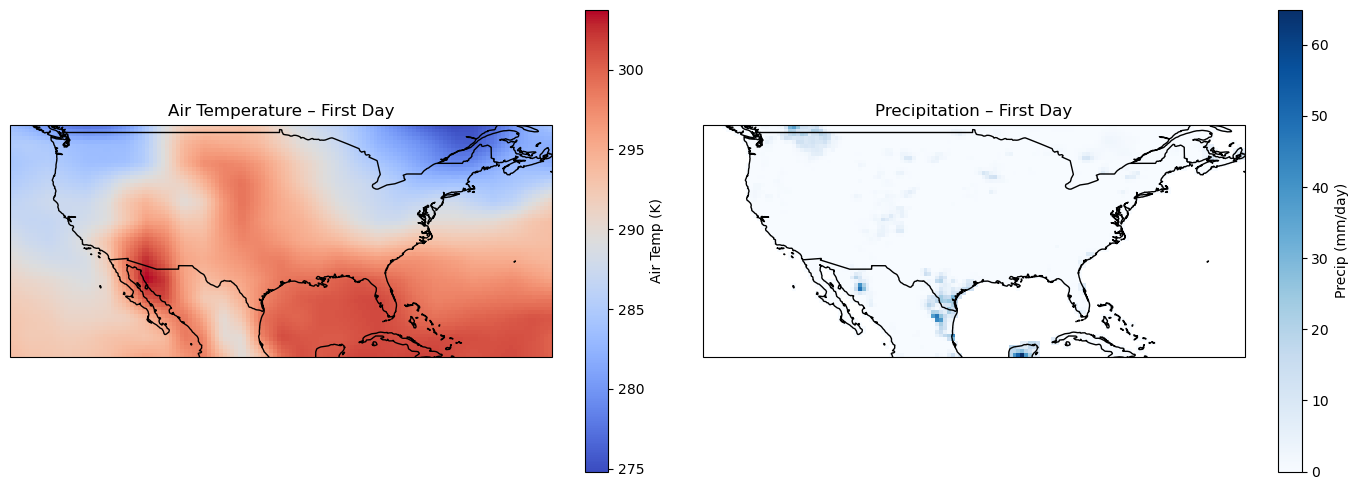

In [14]:
# Create map projection
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(1, 2, figsize=(14, 5),
                         subplot_kw={"projection": proj})

# Plot first timestep of each variable
merged.air_temperature.isel(time=0).plot(
    ax=axes[0], transform=proj, cmap="coolwarm",
    cbar_kwargs={"label": "Air Temp (K)"}
)
axes[0].add_feature(cfeature.COASTLINE)
axes[0].add_feature(cfeature.BORDERS)
axes[0].set_title("Air Temperature – First Day")

merged.daily_precip.isel(time=0).plot(
    ax=axes[1], transform=proj, cmap="Blues",
    cbar_kwargs={"label": "Precip (mm/day)"}
)
axes[1].add_feature(cfeature.COASTLINE)
axes[1].add_feature(cfeature.BORDERS)
axes[1].set_title("Precipitation – First Day")

plt.tight_layout()
plt.show()

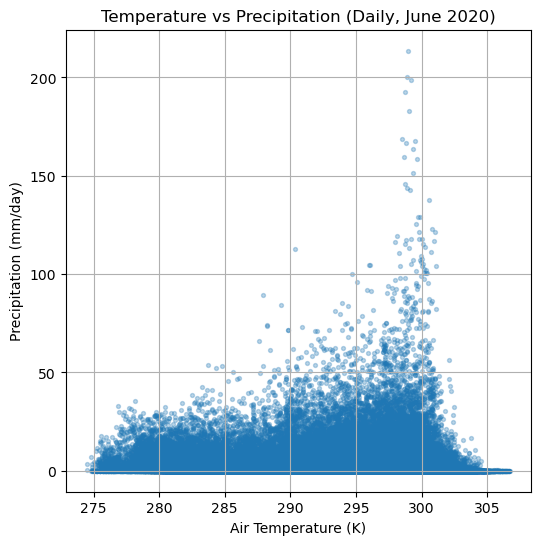

In [17]:
import numpy as np

# Flatten arrays for scatter comparison
x = merged.air_temperature.values.ravel()
y = merged.daily_precip.values.ravel()

# Remove NaNs before plotting
mask = ~np.isnan(x) & ~np.isnan(y)
x, y = x[mask], y[mask]

plt.figure(figsize=(6, 6))
plt.scatter(x, y, s=8, alpha=0.3)
plt.xlabel("Air Temperature (K)")
plt.ylabel("Precipitation (mm/day)")
plt.title("Temperature vs Precipitation (Daily, June 2020)")
plt.grid(True)
plt.show()

In [20]:
# Clear attributes for each variable too
for var in merged.variables:
    merged[var].attrs = {}

merged.attrs = {}
merged.to_netcdf("merged_climate_US_June2020.nc")

In [21]:
import xarray as xr
ds = xr.open_dataset("merged_climate_US_June2020.nc")
print(ds)

<xarray.Dataset> Size: 2MB
Dimensions:          (time: 30, lat: 60, lon: 140)
Coordinates:
  * time             (time) datetime64[ns] 240B 2020-06-01 ... 2020-06-30
  * lat              (lat) float32 240B 49.75 49.25 48.75 ... 21.25 20.75 20.25
  * lon              (lon) float32 560B 230.2 230.8 231.2 ... 298.8 299.2 299.8
Data variables:
    air_temperature  (time, lat, lon) float32 1MB ...
    daily_precip     (time, lat, lon) float32 1MB ...
